**ML Final Project - Classifying Malignant and Benign Breast Cancer Histopathology Images**

Ritika Rajamani & Lalith Suresh 

We utilize datasets off of kaggle and use Kaggle's API to download the datasets. To run our code, you need to move KaggleHub into your scratch. The data is too large to download directly onto the computer's desktop. Uncomment the last line below, and add in the proper username. 

Multiple libraries and packages are needed execution of our code. A list can be found in the README document in the same folder. 

Only the first cell requires any alteration. Every other cell can be run as is on your machine. 

In [104]:
import os
os.environ["KAGGLEHUB_CACHE"] = "/home/rrajama1/scratch/kagglehub"
#os.environ["KAGGLEHUB_CACHE"] = "/home/lsuresh1/scratch/kagglehub"
#os.environ["KAGGLEHUB_CACHE"] = "/home/[yourusername]/scratch/kagglehub

In [105]:
import kagglehub
import torch
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.models as models
from torchvision.models import resnet34, ResNet34_Weights
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from datetime import datetime
from torchsummary import summary

**Downloading and Processing our Dataset**

As this dataset is split into 'malignant' and 'benign' folders, extra pre-processing steps are required in order to consolidate all the data. 

In [106]:
path = kagglehub.dataset_download("anaselmasry/breast-cancer-dataset")
path = os.path.join(path, 'BreaKHis_Total_dataset')
print("Path to dataset files:", path)

Path to dataset files: /home/rrajama1/scratch/kagglehub/datasets/anaselmasry/breast-cancer-dataset/versions/1/BreaKHis_Total_dataset


In [107]:
benign_path = os.path.join(path, 'benign')
malignant_path = os.path.join(path, 'malignant')

This function takes care of mostly all the pre-processing steps required. We are using ResNet-34, which requires images to be 224x224. This function places all images in an array after resizing them. 

In [108]:
def load_dataset(folderpath):
    data = []
    images = sorted(os.listdir(folderpath))
    for image in images:
        filepath = os.path.join(folderpath, image)
        image_data = cv2.imread(filepath, cv2.IMREAD_COLOR)
        image_data = cv2.resize(image_data, (224, 224))
        data.append(image_data)
    return np.array(data)

The steps below make a list of labels to go along with the benign and malignant images. Class '0' is benign while class '1' is malignant. 

In [109]:
benign = load_dataset(benign_path)
benign_labels = np.zeros(2479)

In [110]:
malignant = load_dataset(malignant_path)

In [111]:
malignant_labels = np.ones(5304)

The malignant and benign images are concatenated into one large comprehensive dataset. A separate dataset is also made for the SVM classifier. This classifier requires flattened images, which the last two lines of code perform. 

In [112]:
total_dataset = np.concatenate([benign,malignant], axis=0)
total_labels = np.concatenate([benign_labels, malignant_labels], axis = 0)
total_dataset_SVM = total_dataset.reshape(total_dataset.shape[0], -1)
total_labels_SVM = total_labels.reshape(total_labels.shape[0], -1)

The comprehensive dataset split into train, validation, and test sets usign SciKit Learn's train_test_split(). These splits are exclusively used for the CNN model. The data is split 60-20-20, (train/validation/test).

In [113]:
X_train, X_temp, y_train, y_temp = train_test_split(total_dataset, total_labels, test_size=0.4, random_state=42, stratify = total_labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 42, stratify = y_temp)

**Function for Evaluation**

This function simply plots a non-normalized confusion matrix. This function will be heavily utilized throughout the code. False negatives in medical problems are much more costly than false positives; therefore, visualizing the performance of each model in this way is crucial. 

In [114]:
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**SVM Classifier**

This function simply runs a 5-fold cross validation using a linear SVM classifier with Stochastic Gradient Descent. 5 folds were specifically chosen in order to match the test set size for the CNN. Evaluation of each fold of the SVM classifier can accurately be compared against the CNN's performance.

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

def runTuneTest(learner, parameters, X,y, names):
    """
    Performs end-to-end tuning and testing of hyperparameters associated with specific classifier"
    Params: Base learner object, dictionary of ranges of values for specific hyperparameters, feature data, labels, and the target names for plotting the confusion matrix
    Returns: list of accuracies for each fold 
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    accuracies = []
    y_true_all = np.zeros(len(y), dtype=int)   
    y_pred_all = np.zeros(len(y), dtype=int)  
    y_score_all = np.zeros(len(y), dtype=float)
    predictions = np.zeros(len(y), dtype = int)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):

        # selecting rows for training and testing
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        grid = GridSearchCV(learner, parameters, cv=3)
        grid.fit(X_train, y_train)

        accuracy = grid.score(X_test, y_test)
        accuracies.append(accuracy)

        pred = grid.predict(X_test)
        predictions[test_index] = pred
        scores = grid.decision_function(X_test)

        y_true_all[test_index] = y_test
        y_pred_all[test_index] = pred
        y_score_all[test_index] = scores
        
 
        print("Fold %d" % (i+1))
        print(f"Best parameters: {grid.best_params_}")
        print(f"Tuning set score: {grid.best_score_}")
        print(" ")

        confusionmatrix = confusion_matrix(y_test, pred)
        print("Confusion  matrix over Fold %d" %(i+1))
        print(confusionmatrix)
        plot_confusion_matrix(confusionmatrix, names) 
        plt.show()

    f1 = f1_score(y_true_all, y_pred_all)
    auc = roc_auc_score(y_true_all, y_score_all)

    print("Overall F1-score SVM:", f1)
    print("Overall ROC-AUC SVM:", auc)
            
    return accuracies

This simply runs the cross validation pipeline. Multiple alpha values are given, which will be optimized during cross-validation. Evaluation metrics are also printed to the screen. Evaluation includes confusion matrices for each fold, per-fold accuracies, mean accuracy, overall F1, and overall ROC-AUC. 

Fold 1
Best parameters: {'sgdclassifier__alpha': 0.001}
Tuning set score: 0.7619655500615178
 
Confusion  matrix over Fold 1
[[229 267]
 [ 96 965]]


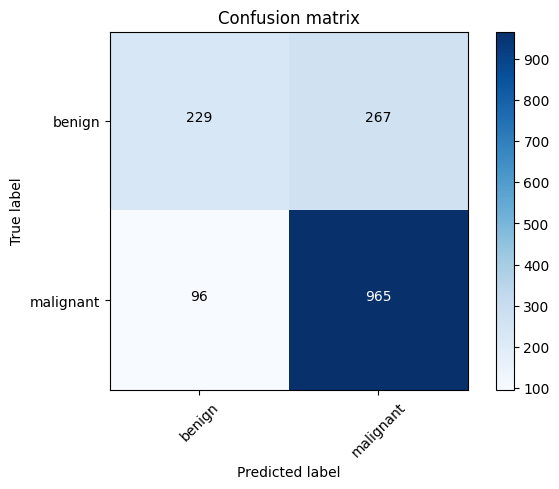

Fold 2
Best parameters: {'sgdclassifier__alpha': 0.01}
Tuning set score: 0.7627680664855956
 
Confusion  matrix over Fold 2
[[ 235  261]
 [  59 1002]]


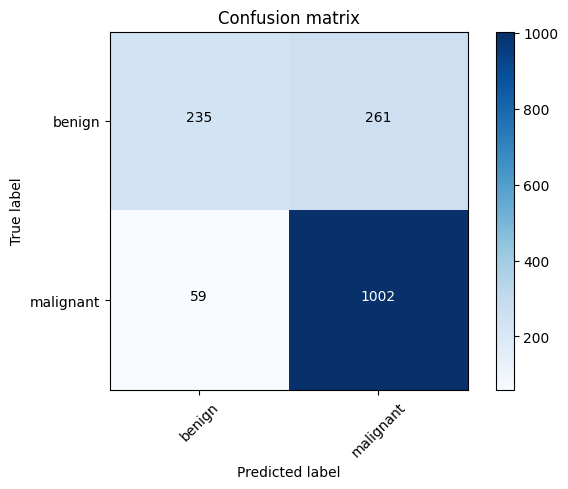

Fold 3
Best parameters: {'sgdclassifier__alpha': 0.01}
Tuning set score: 0.7671029396971315
 
Confusion  matrix over Fold 3
[[253 243]
 [ 97 964]]


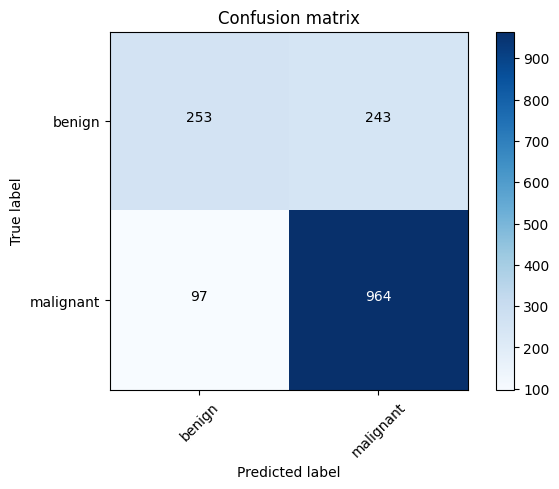

Fold 4
Best parameters: {'sgdclassifier__alpha': 0.01}
Tuning set score: 0.7756464006314275
 
Confusion  matrix over Fold 4
[[237 259]
 [ 85 975]]


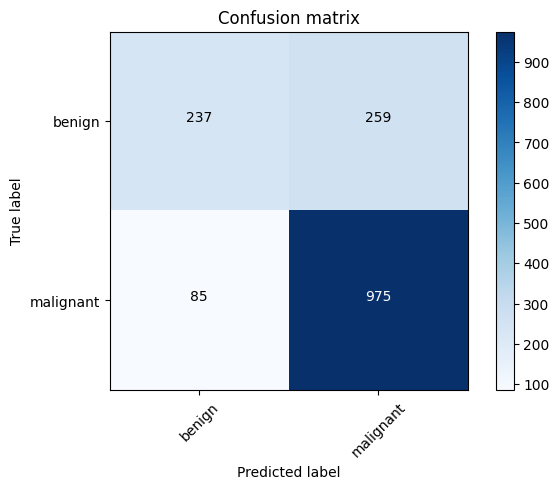

Fold 5
Best parameters: {'sgdclassifier__alpha': 0.01}
Tuning set score: 0.7658540133559285
 
Confusion  matrix over Fold 5
[[240 255]
 [ 79 982]]


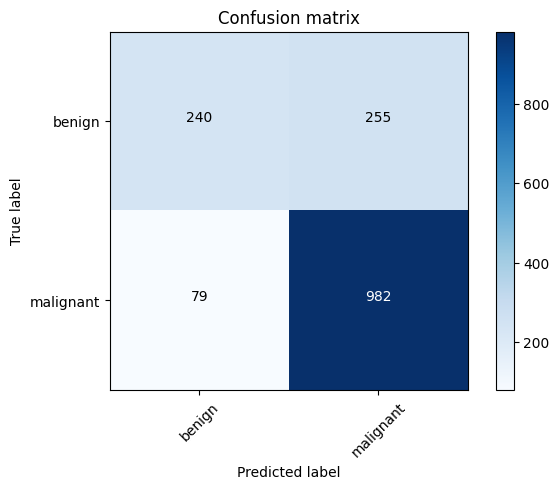

Overall F1-score SVM: 0.851790537596933
Overall ROC-AUC SVM: 0.7938781541722719
Per-fold accuracies: [0.766859344894027, 0.7944765574823378, 0.781631342324984, 0.7789203084832905, 0.7853470437017995]
Mean CV accuracy: 0.7814469193772877


In [24]:
sgd2 = make_pipeline(
    StandardScaler(),
    SGDClassifier(
        loss="hinge",       
        penalty="l2",
        alpha=1e-4,
        max_iter=2000,
        tol=1e-3,
        random_state=42
    )
)
parameters = {
    "sgdclassifier__alpha": [1e-4, 1e-3, 1e-2]
}
class_names = ["benign", "malignant"]

sgd2_accuracies = runTuneTest(sgd2, parameters, total_dataset_SVM, total_labels, class_names)

print("Per-fold accuracies:", sgd2_accuracies)
print("Mean CV accuracy:", np.mean(sgd2_accuracies))

**CNN Classifier**

To begin, we create a BreastCancer_Dataset class which allows us to apply specific transforms during training, validation, and testing. Additionally, PyTorch's DataLoader requires this format. 

In [130]:
#making class for CNN data
class BreastCancer_Dataset(Dataset):
    def __init__(self, images, labels, transform = None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        img = torch.from_numpy(img).float()
        img = img.permute(2,0,1)
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype = torch.long)
        return img, label
        
    

The code below sets up the ResNet-34 model from PyTorch. As the dataset we will be training on is quite small, only the last two residual blocks of the model are unfrozen. All previous layers keep their pre-trained weights from Imagenet. 

In [131]:
#Resnet model + unfreezing certain layers 
class R34(nn.Module):
    def __init__(self, num_cls=2, freeze_backbone=True):
        super(R34, self).__init__()
        resnet = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.backbone = nn.Sequential(OrderedDict([*(list(resnet.named_children())[:-2])]))

        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            for param in resnet.layer4.parameters():
                param.requires_grad = True
            for param in resnet.layer3.parameters():
                param.requires_grad = True
            

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512,num_cls)

    def forward(self, img):
        feat_map = self.backbone(img)
        feat_1d = self.avgpool(feat_map).flatten(1)
        logit = self.classifier(feat_1d)
        
        return logit

These next three functions perform the training, validation and testing stages of our CNN. The model is trained across multiple epochs, and utilizes Mini-Batch Gradient Descent. The model with the best validation accuracy is saved for the inference phase. The TQDM library is used to show progress bar during training and validation. Additionally, the TensorBoard library is utilized to plot loss and accuracy across epochs.

In [132]:
#validation run (one epoch)
def run_val_epoch(model, data, criterion):
    model.eval()

    sum_loss = 0
    correct = 0
    num_samples = 0
    with torch.no_grad():
        for idx, (img, label) in enumerate(data):
            img, label = img.to(device), label.to(device)

            num_batch = label.shape[0]
            img = img.to(device).float()
            label = label.to(device).long()
            output = model(img)
            _, pred = torch.max(output, 1)
            correct += pred.eq(label.data).sum().item()

            loss = criterion(output, label)
            sum_loss += num_batch*(loss.item())
            num_samples += num_batch

    loss = sum_loss / num_samples
    acc = 100 * correct / num_samples

    return loss, acc

In [133]:
#train and validation for num_epochs
def run_trainval(model, train_data, val_data, criterion, optimizer, device, num_epochs, scheduler):
    ep = -1
    best_val_acc = 0.0
    val_loss, val_acc = run_val_epoch(model, val_data, criterion)
    print(f"[val-{ep + 1}/{num_epochs}] loss: {val_loss:.6f} | acc: {val_acc:.3f}%")
    writer.add_scalar('ep_loss/val', val_loss, ep+1)
    writer.add_scalar('ep_acc/val', val_acc, ep+1)

    for ep in range(num_epochs):
        model.train()
        ep_loss = 0
        ep_pred, ep_labels = [], []
        start_time = datetime.now()

        for idx, (img, label) in enumerate(tqdm(train_data)):
            img, label = img.to(device), label.to(device)
            pred = model(img)
            loss = criterion(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ep_loss += len(label) * loss.item()

            ep_pred.append(pred.detach().max(dim=1)[1].cpu())
            ep_labels.append(label.cpu())
        
        end_time = datetime.now()
        print(f"Time elapsed {end_time - start_time}")

        ep_pred = torch.cat(ep_pred)
        ep_labels = torch.cat(ep_labels)
        train_loss = ep_loss / len(ep_labels)
        train_acc = 100 * (ep_labels == ep_pred).to(float).mean().item()
        val_loss, val_acc = run_val_epoch(model, val_data, criterion)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best.pt')
            print(f"[INFO] Saved best model at epoch {ep+1} with val acc {val_acc:.2f}%")

        print(f"[train-{ep + 1}/{num_epochs}] loss: {train_loss:.6f} | acc: {train_acc:.3f}%")
        print(f"[val-{ep + 1}/{num_epochs}] loss: {val_loss:.6f} | acc: {val_acc:.3f}%")
        writer.add_scalar('ep_loss/train', train_loss, ep+1)
        writer.add_scalar('ep_loss/val', val_loss, ep+1)
        writer.add_scalar('ep_acc/train', train_acc, ep+1)
        writer.add_scalar('ep_acc/val', val_acc, ep+1)
        scheduler.step()

In [134]:
#test set code 
def run_test(model, data, criterion):
    model.eval()

    sum_loss = 0
    correct = 0
    num_samples = 0
    preds = []
    scores = []
    
    with torch.no_grad():
        for idx, (img, label) in enumerate(data):
            img, label = img.to(device), label.to(device)
            num_batch = label.shape[0]
            img = img.to(device).float()
            label = label.to(device).long()
            output = model(img)
            _, pred = torch.max(output, 1)
            correct += pred.eq(label.data).sum().item()

            prob_malignant = F.softmax(output, dim=1)[:, 1]

            loss = criterion(output, label)
            sum_loss += num_batch*(loss.item())
            num_samples += num_batch

            scores.append(prob_malignant.cpu())
            preds.append(pred.cpu())
    preds = torch.cat(preds).numpy() 
    scores = torch.cat(scores).numpy()
    loss = sum_loss / num_samples
    acc = 100 * correct / num_samples
    print(f"[test] loss: {loss:.6f} | acc: {acc:.3f}%")
    return preds, scores


These are the hyper-parameters we have ultimately settled on. These values achieved a test accuracy of 98.53%. Multi-cropping during the inference stage was not performed as can be seen by the crop_size of 224. 

In [135]:
#hyperparameters
batch_size = 15
num_epochs = 20
num_workers = 5
lr = 5e-4
regularization = 1e-4
crop_size = 224

Loading of the dataset into the correct format for the CNN. Images are normalized, and specific transformations are applied. The same transformations applied to the validation set are applied to our test set. 

In [139]:
#loading in our dataset 
normalize = T.Normalize(mean = [0.485,0.456, 0.406], std =[0.229,0.224,0.225])
train_transform = T.Compose(
    [
        normalize,
        T.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
    ])
val_transform = T.Compose(
    [
        normalize
    ])
train_dataset = BreastCancer_Dataset(X_train, y_train, train_transform)
val_dataset =  BreastCancer_Dataset(X_val, y_val, val_transform)
test_dataset = BreastCancer_Dataset(X_test, y_test, val_transform)

train = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers, pin_memory = True)
val = DataLoader(val_dataset, batch_size = batch_size, num_workers = num_workers, pin_memory = True)
test = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, pin_memory = True)

**Training and Validation Stage:** 

The Adam optimizer was chosen for its adaptability with weight updates. A Cosine Annealing learning rate scheduler was also applied in order to achieve a smoother convergence. 

In [140]:
#setting up model and running train/validation
device = "cuda" if torch.cuda.is_available() else "cpu"
writer = SummaryWriter(log_dir="runs") #saves event files into folder named 'runs' 
model = R34(num_cls = 2, freeze_backbone = True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = lr, weight_decay = regularization)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
run_trainval(model, train, val, criterion, optimizer, device, num_epochs, scheduler)

[val-0/20] loss: 6.133691 | acc: 44.958%


100%|█████████████████████████████████████████████| 312/312 [00:35<00:00,  8.91it/s]

Time elapsed 0:00:35.012863


[INFO] Saved best model at epoch 1 with val acc 91.65%
[train-1/20] loss: 0.349048 | acc: 85.993%
[val-1/20] loss: 0.210256 | acc: 91.651%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.51it/s]

Time elapsed 0:00:36.675222


[train-2/20] loss: 0.239097 | acc: 90.276%
[val-2/20] loss: 0.653662 | acc: 89.403%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.44it/s]

Time elapsed 0:00:36.974880


[INFO] Saved best model at epoch 3 with val acc 92.74%
[train-3/20] loss: 0.215820 | acc: 91.540%
[val-3/20] loss: 0.188932 | acc: 92.742%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.51it/s]

Time elapsed 0:00:36.666629


[INFO] Saved best model at epoch 4 with val acc 94.67%
[train-4/20] loss: 0.195837 | acc: 92.268%
[val-4/20] loss: 0.150636 | acc: 94.669%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.54it/s]

Time elapsed 0:00:36.554970


[INFO] Saved best model at epoch 5 with val acc 94.99%
[train-5/20] loss: 0.184632 | acc: 92.889%
[val-5/20] loss: 0.138993 | acc: 94.990%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.57it/s]

Time elapsed 0:00:36.396270


[train-6/20] loss: 0.176702 | acc: 93.018%
[val-6/20] loss: 0.149307 | acc: 93.834%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.52it/s]


Time elapsed 0:00:36.626749
[train-7/20] loss: 0.160970 | acc: 93.874%
[val-7/20] loss: 0.154070 | acc: 93.963%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.54it/s]

Time elapsed 0:00:36.538882


[INFO] Saved best model at epoch 8 with val acc 96.47%
[train-8/20] loss: 0.155189 | acc: 94.089%
[val-8/20] loss: 0.103601 | acc: 96.468%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.61it/s]

Time elapsed 0:00:36.247339


[train-9/20] loss: 0.122713 | acc: 95.331%
[val-9/20] loss: 0.111078 | acc: 95.633%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.58it/s]

Time elapsed 0:00:36.367208


[train-10/20] loss: 0.132836 | acc: 95.267%
[val-10/20] loss: 0.140014 | acc: 94.990%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.59it/s]

Time elapsed 0:00:36.338678


[INFO] Saved best model at epoch 11 with val acc 96.98%
[train-11/20] loss: 0.107278 | acc: 96.123%
[val-11/20] loss: 0.093572 | acc: 96.981%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.65it/s]

Time elapsed 0:00:36.083611


[INFO] Saved best model at epoch 12 with val acc 97.75%
[train-12/20] loss: 0.101426 | acc: 96.402%
[val-12/20] loss: 0.079464 | acc: 97.752%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.63it/s]

Time elapsed 0:00:36.172055


[train-13/20] loss: 0.093411 | acc: 96.595%
[val-13/20] loss: 0.076160 | acc: 97.303%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.56it/s]

Time elapsed 0:00:36.442361


[train-14/20] loss: 0.074585 | acc: 97.430%
[val-14/20] loss: 0.067617 | acc: 97.688%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.58it/s]

Time elapsed 0:00:36.369045


[train-15/20] loss: 0.064304 | acc: 97.751%
[val-15/20] loss: 0.067742 | acc: 97.174%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.54it/s]

Time elapsed 0:00:36.537421


[train-16/20] loss: 0.058895 | acc: 98.115%
[val-16/20] loss: 0.084548 | acc: 96.853%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.55it/s]

Time elapsed 0:00:36.485704


[INFO] Saved best model at epoch 17 with val acc 98.20%
[train-17/20] loss: 0.048969 | acc: 98.244%
[val-17/20] loss: 0.054293 | acc: 98.202%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.63it/s]

Time elapsed 0:00:36.136722


[train-18/20] loss: 0.040413 | acc: 98.415%
[val-18/20] loss: 0.055385 | acc: 97.816%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.57it/s]

Time elapsed 0:00:36.410122


[train-19/20] loss: 0.032901 | acc: 98.886%
[val-19/20] loss: 0.057804 | acc: 97.881%


100%|█████████████████████████████████████████████| 312/312 [00:36<00:00,  8.60it/s]

Time elapsed 0:00:36.292041


[train-20/20] loss: 0.038180 | acc: 98.629%
[val-20/20] loss: 0.055352 | acc: 97.752%


**Inference Stage:**

The best model from the validation stage performs the classification on the test set. All evaluation metrics and a summary of the best model are printed to the screen. 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

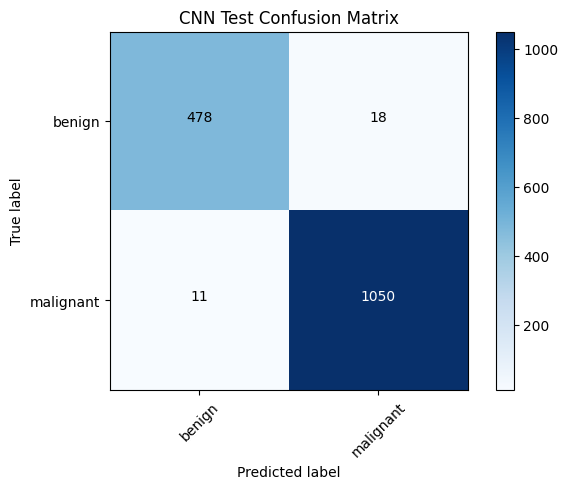

In [141]:
#load best model from validation phase, print summary of the model
model.load_state_dict(torch.load('best.pt'))
summary(model, input_size=(3, crop_size, crop_size))
preds, scores = run_test(model, test, criterion)
cnn_f1 = f1_score(y_test, preds)
print("CNN F1 Score:", cnn_f1)
cnn_auc = roc_auc_score(y_test, scores)
print("CNN ROC-AUC curve:", cnn_auc)

#print confusion matrix 
confusionmatrix = confusion_matrix(y_test, preds)
print("Confusion Matrix for Best Model")
print(confusionmatrix)
class_names = ["benign", "malignant"]
plot_confusion_matrix(confusionmatrix, class_names, title = "CNN Test Confusion Matrix") 
plt.show()


**Evaluating Real World Performance Accurately**

Studies have noted that the test accuracy presented is not always accurate. The dataset we chose is taken from 82 patients. This means many of the images in the test set are from patients who the model has already seen during the training and validation stage. Thus, real-world performance was evaluated by testing the best model on a completely new patient. 

A new dataset was found off of kaggle. It is extremely large and takes data from 279 different patients. The data is once again split up already into malignant and benign folders. However, the data is also split up by each patient. Thus, to evaluate, one specific patient, Patient 10264, was selected. This patient was chosen as there is a well balanced ratio of benign to malignant images (618 to 587). All pre-processing steps performed on the previous dataset were repeated here. The only exception is that no train-validation-split was performed as this whole dataset will be used as the testing dataset. This dataset is extremely large, so the download/extraction process will take a while. After extracting the images, loading the dataset and pre-processing is very quick as we are only utilizing one patient's data.

In [142]:
#trying our best model on a completely new dataset:
test_path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")
test_path = os.path.join(test_path, 'IDC_regular_ps50_idx5/10264')
print("Path to dataset files:", test_path)
benign_path2 = os.path.join(test_path, '0')
malignant_path2 = os.path.join(test_path, '1')

Path to dataset files: /home/rrajama1/scratch/kagglehub/datasets/paultimothymooney/breast-histopathology-images/versions/1/IDC_regular_ps50_idx5/10264


In [143]:
benign2 = load_dataset(benign_path2)
benign_labels2 = np.zeros(617)
malignant2 = load_dataset(malignant_path2)
malignant_labels2 = np.ones(587)

In [144]:
total_dataset2 = np.concatenate([benign2,malignant2], axis=0)
total_labels2 = np.concatenate([benign_labels2, malignant_labels2], axis = 0)
random = np.random.permutation(len(total_dataset2))

# Apply the same permutation to both arrays
new_test = total_dataset2[random]
new_labels = total_labels2[random]

In [145]:
test_dataset2 = BreastCancer_Dataset(new_test, new_labels, val_transform)
test2 = DataLoader(test_dataset2, batch_size = batch_size, num_workers = num_workers, pin_memory = True)

**Evaluation of Real-World Performance**

All metrics performed before were also performed here. As can be seen below, the model performs terribly on completely new data. This highlights why ML models have not made their way into the medical field just yet. While the accuracy previously seemed trustworthy, this CNN does not actually perform well when seeing data from a new patient. 

[test] loss: 1.577099 | acc: 50.332%
CNN F1 Score: 0.6575028636884307
CNN ROC-AUC curve: 0.5960947487292194
Confusion Matrix for Best Model
[[ 32 585]
 [ 13 574]]


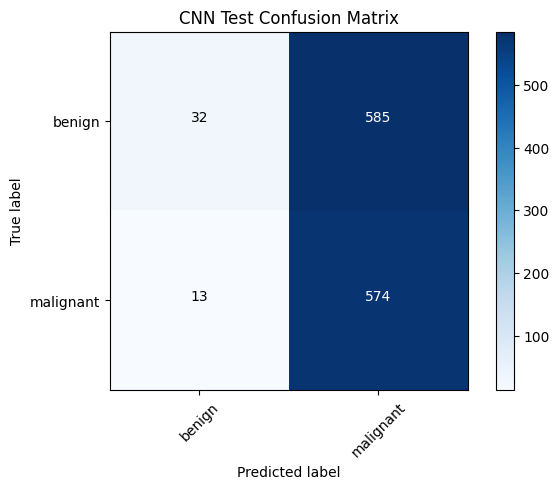

In [146]:
preds2, scores2 = run_test(model, test2, criterion)
cnn_f1 = f1_score(new_labels, preds2)
print("CNN F1 Score:", cnn_f1)
cnn_auc = roc_auc_score(new_labels, scores2)
print("CNN ROC-AUC curve:", cnn_auc)

#print confusion matrix 
confusionmatrix = confusion_matrix(new_labels, preds2)
print("Confusion Matrix for Best Model")
print(confusionmatrix)
class_names = ["benign", "malignant"]
plot_confusion_matrix(confusionmatrix, class_names, title = "CNN Test Confusion Matrix") 
plt.show()